In [57]:
import pandas as pd
import utils.utils_models as utils_models
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from utils.utils_models import LightGBMForecastingModel

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features
from utils.utils_features_family import ExtractFamilyFeatures
import matplotlib.pyplot as plt



In [27]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

In [28]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")

In [29]:
df_monthly = utils_preprocessing.aggregate_data(
    df, 
    frequency="ME"
    )
df_monthly = utils_preprocessing.fill_in_missing_dates(
    df_monthly, 
    group_col=["brand", "family"], 
    date_col="date", 
    freq="ME"
    )

In [34]:
df_monthly = df_monthly.groupby("date")["total_revenue"].sum().reset_index()

In [35]:
df_monthly = utils_features.features_time_related(df_monthly, frequency='ME')
df_monthly = utils_features.features_lag(
    df=df_monthly, 
    col="total_revenue",
    lags=[12, 13, 14],
    group_column=[]
)

In [36]:
# processor = ExtractFamilyFeatures()
# df_monthly = processor(df_monthly) 

In [37]:
df_monthly.dtypes

date                    datetime64[ns]
total_revenue                  float32
year                             int32
month_of_year                    int32
sin_month_of_year              float64
cos_month_of_year              float64
total_revenue_lag_12           float32
total_revenue_lag_13           float32
total_revenue_lag_14           float32
dtype: object

In [39]:
# cols_categorical = ['brand', 'family'] #, 'clothing_type', 'sport_category', 'outlet_flag']
# for col in cols_categorical:
#     df_monthly[col] = df_monthly[col].astype("category")
df_monthly = df_monthly.rename(columns={"total_revenue": "y"}).set_index("date")

In [40]:
df_monthly

,y,year,month_of_year,sin_month_of_year,cos_month_of_year,total_revenue_lag_12,total_revenue_lag_13,total_revenue_lag_14
date,,,,,,,,
2020-09-30,37687.968750,2020,9,-1.000,-0.000,NaN,NaN,NaN
2020-10-31,44129.101562,2020,10,-0.866,0.500,NaN,NaN,NaN
2020-11-30,64818.648438,2020,11,-0.500,0.866,NaN,NaN,NaN
2020-12-31,75439.960938,2020,12,-0.000,1.000,NaN,NaN,NaN
2021-01-31,93688.390625,2021,1,0.500,0.866,NaN,NaN,NaN
2021-02-28,77470.453125,2021,2,0.866,0.500,NaN,NaN,NaN
2021-03-31,100129.578125,2021,3,1.000,0.000,NaN,NaN,NaN
2021-04-30,101728.671875,2021,4,0.866,-0.500,NaN,NaN,NaN
2021-05-31,94235.937500,2021,5,0.500,-0.866,NaN,NaN,NaN


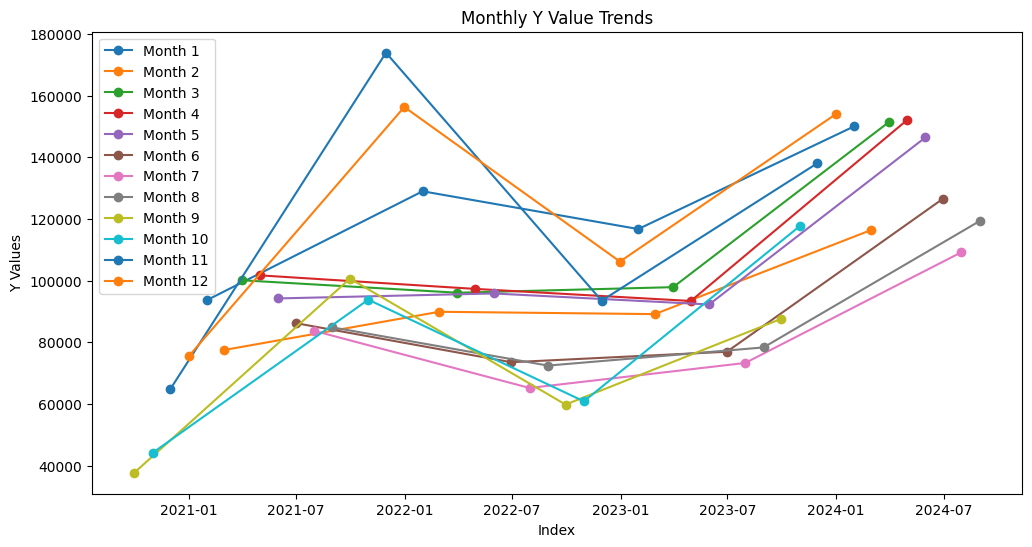

In [ ]:
plt.figure(figsize=(12, 6)) 
for month in range(1, 13):
    monthly_data = df_monthly[df_monthly["month_of_year"] == month]  
    plt.plot(
        monthly_data['y'], 
        label=f'Month {month}', 
        marker='o'  
    )

plt.xlabel("Index")
plt.ylabel("Y Values")
plt.title("Monthly Y Value Trends")
plt.legend()
plt.show()

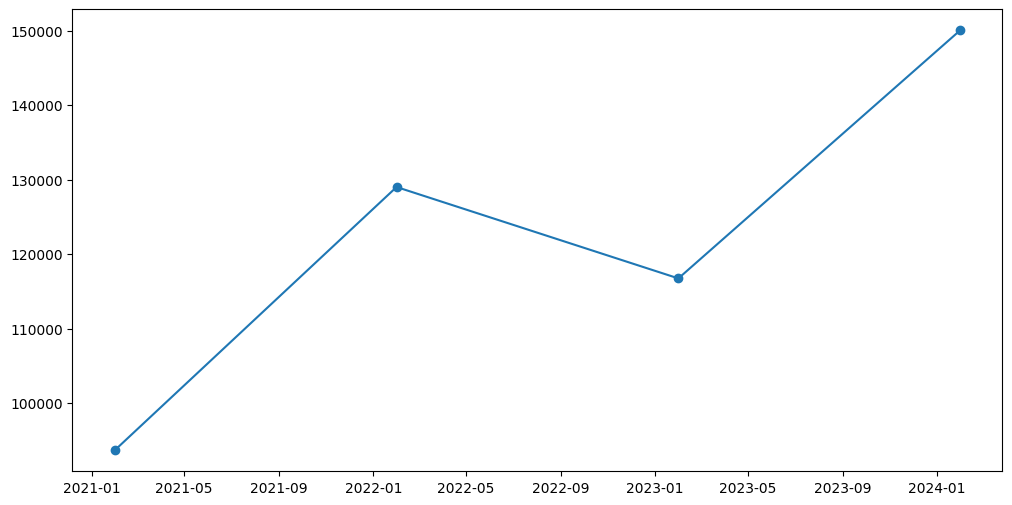

In [64]:
plt.figure(figsize=(12, 6)) 
monthly_data = df_monthly[df_monthly["month_of_year"] == 1]  
plt.plot(
    monthly_data['y'], 
    label=f'Month {month}', 
    marker='o'  
)

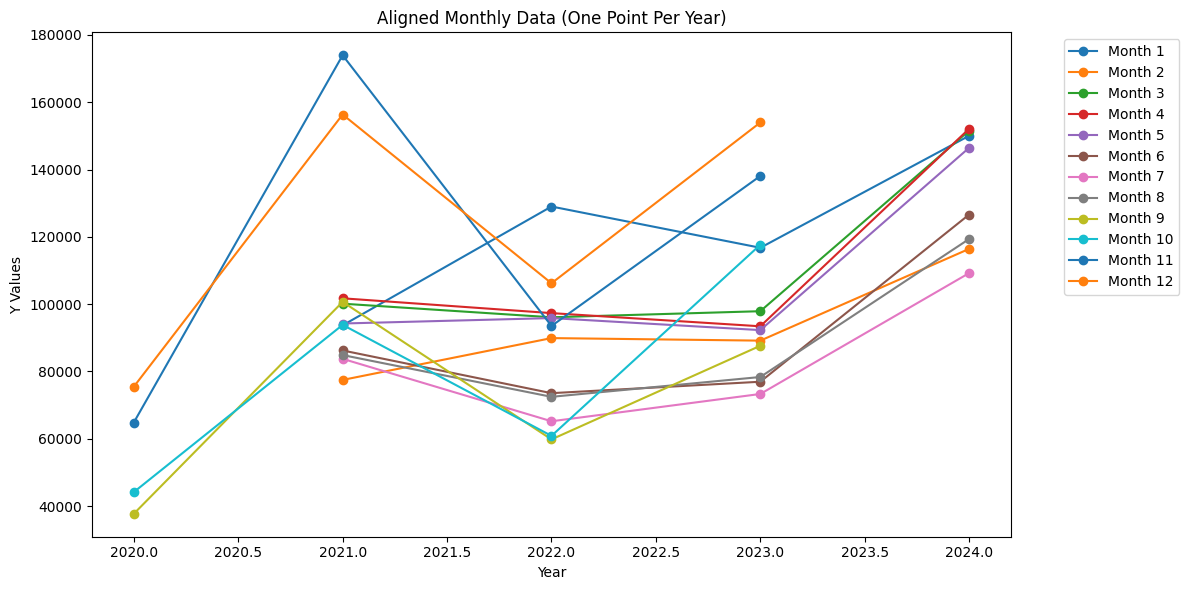

In [65]:
plt.figure(figsize=(12, 6))

# Extract the unique years from the DataFrame
years = df_monthly['year'].unique()

# Loop through each month and plot the points (one point per year)
for month in range(1, 13):
    # Filter the data for the specific month
    monthly_data = df_monthly[df_monthly["month_of_year"] == month]
    
    # Align points by using 'year' as the x-axis and 'y' as the y-axis
    plt.plot(
        monthly_data['year'],  # X-axis: years
        monthly_data['y'],     # Y-axis: values
        marker='o',            # Use markers to emphasize points
        label=f'Month {month}' # Label for the legend
    )

# Add labels, legend, and title
plt.xlabel("Year")
plt.ylabel("Y Values")
plt.title("Aligned Monthly Data (One Point Per Year)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [67]:
df_monthly.shape

(48, 8)

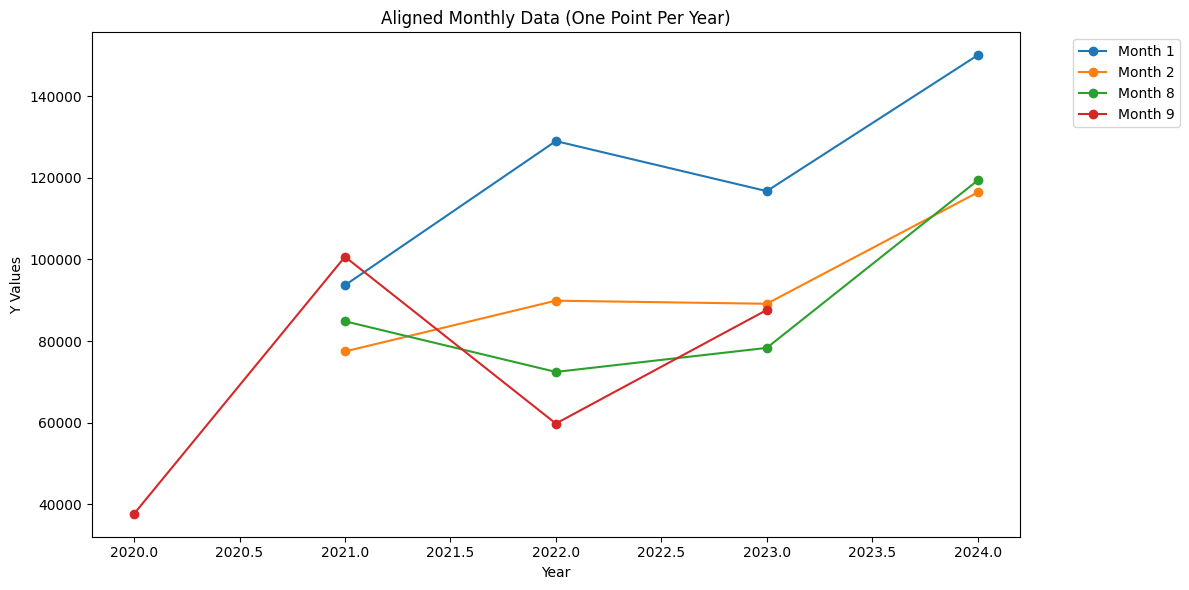

In [66]:
plt.figure(figsize=(12, 6))

# Extract the unique years from the DataFrame
years = df_monthly['year'].unique()

# Loop through each month and plot the points (one point per year)
for month in [1,2, 8, 9]:
    # Filter the data for the specific month
    monthly_data = df_monthly[df_monthly["month_of_year"] == month]
    
    # Align points by using 'year' as the x-axis and 'y' as the y-axis
    plt.plot(
        monthly_data['year'],  # X-axis: years
        monthly_data['y'],     # Y-axis: values
        marker='o',            # Use markers to emphasize points
        label=f'Month {month}' # Label for the legend
    )

# Add labels, legend, and title
plt.xlabel("Year")
plt.ylabel("Y Values")
plt.title("Aligned Monthly Data (One Point Per Year)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

In [41]:
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [42]:
cv_split = TimeSeriesSplit(n_splits=2, test_size=12)

In [43]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    'verbosity': [-1],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packa

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=12),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'verbosity': [-1]},
                   verbose=1)

In [44]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [45]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.3,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'num_leaves': 100,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 50,
 'reg_lambda': 0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

In [46]:
tss = TimeSeriesSplit(2, test_size=12)

fc_model = LightGBMForecastingModel(hyperparameters=optimal_params)
results_cv = fc_model.cross_validate(df_monthly, n_splits=2)

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]


KeyError: 'brand'

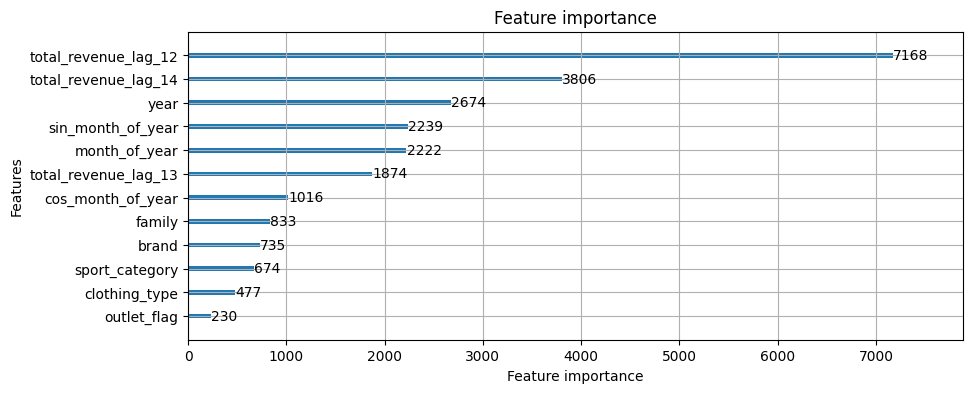

In [22]:
fc_model.plot_feature_importance()

In [23]:
y_preds = fc_model.predict(X=X_test)
df_preds = pd.DataFrame(
    data={
        "brand": X_test["brand"],
        "family": X_test["family"],
        "y_pred": y_preds,
        "y": y_test.values
    },
    index=X_test.index,
)

In [24]:
df_preds

,brand,family,y_pred,y
date,,,,
2023-09-30,adidas,Chanclas Urban,402.819019,675.000000
2023-09-30,adidas,Camisetas Outdoor,336.933075,164.899994
2023-09-30,Columbia,Calzado Après-Ski,-231.989308,300.000000
2023-09-30,Columbia,Headwear Outdoor,666.843354,160.000000
2023-09-30,Columbia,Zapatillas de montaña,868.184619,2347.800049
...,...,...,...,...
2024-08-31,adidas,Zapatillas Trail Running,4696.391894,8835.250977
2024-08-31,adidas,Outlet Zapatillas Running,-159.979682,470.000000
2024-08-31,Columbia,Headwear Outdoor,-125.088325,1353.000000


In [27]:
df_monthly["sport_category"].value_counts()

sport_category
urban                         974
outdoor                       670
running                       449
training                      305
de montaña                    278
natación                      163
ciclismo                      127
unknown                       110
trail running                  93
esquí                          92
fitness                        82
interior y térmica outdoor     41
piscina                        36
après-ski                      25
triatlón running               16
homewear                        9
interior urban                  6
yoga                            3
Name: count, dtype: int64

<Axes: xlabel='date'>

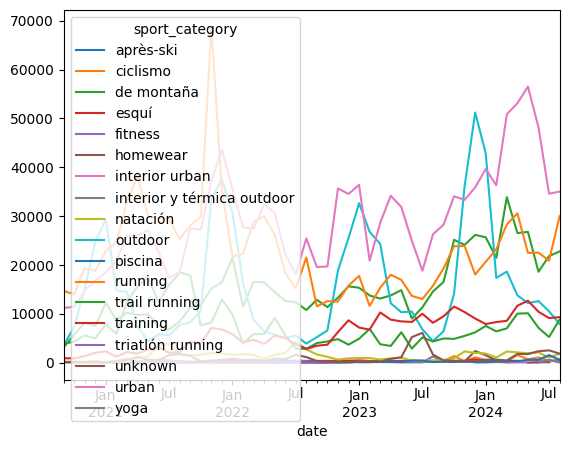

In [28]:
df_monthly.groupby(['date', 'sport_category'])['total_revenue'].sum().unstack().plot()